# Solving Pong with a policy network

This example notebook solves Pong with a very simple *Policy Network* and the Pytorch environment.

The image preprocessing is copied from [Andrej Karpathy's gist](https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5) which implements a similar network and gradient descent using low-level `numpy` code.

We start by installing gymnasium (the officialy maintained version of OpenAI gym).
Please be aware that the download of the Atari ROMs is subject to specific terms (education and research use only).

In [1]:
!pip install gymnasium[atari] gymnasium[accept-rom-license]

In [18]:
import gymnasium as gym
import random 
import torch
import numpy as np
from torch import nn
from torch.distributions import Bernoulli

from gymnasium import wrappers
import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm

# enable simple browser-based rendering
do_render = True

# create the Pong environment
env = gym.make("ALE/Pong-v5", render_mode="rgb_array")

## Rendering using `matplotlib`

In this Jupyter environment we can't use the usual rendering routines as the depend on some kind of display.
Since the screen is very small, we can just render the bitmap using `matplotlib`.

In [9]:
def render(env):
    if do_render:
        img.set_data(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)

## Preprocessing the images

The following code preprocesses the images, removing unnecessary information. This help speeding up the training. 

In [10]:
def preprocess(x):
    """ 
    Preprocess 210x160x3 uint8 frame into 6000 (75x80) 1D float vector 
    
    The preprocessing code was copied from 
    [Andrej Karpathy's gist](https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5)
    """
    x = x[35:185]       # crop - remove 35px from start & 25px from end of image in x, to reduce redundant parts of image (i.e. after ball passes paddle)
    x = x[::2, ::2, 0]  # downsample by factor of 2.
    x[x == 144] = 0     # erase background (background type 1)
    x[x == 109] = 0     # erase background (background type 2)
    
    # everything else (paddles, ball) just set to 1. this makes the image grayscale effectively
    x[x != 0] = 1
    
    return torch.tensor(x).float().flatten()

## Defining a policy making random moves

This 'stupid' policy just makes random moves with the paddle and does not learn. 

In [19]:
class RandomPolicy:
    
    def __call__(self, observation):
        return random.choice([0, 2, 3])
    
    def update(self, *args):
        # Do nothing
        pass
    
    def init_game(self, observation):
        pass
    
policy = RandomPolicy()

## The main loop for playing and training

The following code plays 10.000 games with a `policy`.

If you use this for training, be sure to set `do_render` to `False` to speed things up.

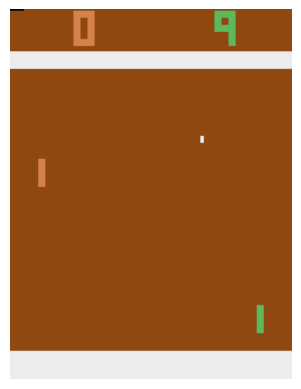

In [17]:
observation, info = env.reset()
observation = preprocess(observation)
policy.init_game(observation)

plt.ion()
plt.axis('off')
img = plt.imshow(env.render())

with tqdm(total=10000) as pbar:
    while True:
        try:
            action = policy(observation)
            observation, reward, terminated, truncated, info = env.step(action)
            observation = preprocess(observation)
            render(env)
            policy.update(observation, reward, terminated, truncated, info, pbar)

            if terminated or truncated:
                pbar.update()
                observation, info = env.reset()
                observation = preprocess(observation)
                policy.init_game(observation)
                
        except KeyboardInterrupt:
            break
env.close()



## A simple policy network

The following code defines a simple neural network with a single hidden layer an a single output neuron.
The activation of the output neuron is interpreted as the probability of moving the paddle UP.

Learning takes place in the `update()` function which defines a simple loss function based on discounted rewards. 

In [13]:
hidden_size = 200

class PolicyNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Preprocessed input is 75 * 80
        self.fc1 = nn.Linear(75 * 80, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        
        
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.sigmoid(self.fc2(x))
        return x

class SimplePolicy:
    
    def __init__(self):
        # Two possible actions (UP, DOWN)
        self.ACTIONS = [2, 3]       
        self.net = PolicyNetwork()
        self.optimizer = torch.optim.RMSprop(self.net.parameters(), lr=0.001)
        self.mean_reward = None
        self.games = 0
        self.gamma = 0.99
        
    def __call__(self, observation):
        diff = observation - self.last_observation
        p = self.net(diff)
        m = Bernoulli(p)
        action = m.sample()
        
        self.diffs.append(diff)
        self.actions.append(action)
        self.last_observation = observation
        
        return self.ACTIONS[int(action.item())]
        
    def init_game(self, observation):
        self.last_observation = observation
        self.diffs = []
        self.actions = []
        self.rewards = []
        self.total_reward = 0
        
        
    def discount_rewards(self, r):
        discounted = torch.zeros(len(r))
        summe = 0
        for t in reversed(range(0, len(r))):
            if r[t] != 0:
                # reset the sum, since this was a game boundary (pong specific!)
                summe = 0
            summe = summe * self.gamma + r[t]
            discounted[t] = summe
        return discounted
        
    def update(self, observation, reward, terminated, truncated, info, pbar):
        self.total_reward += reward
        self.rewards.append(reward)
        if terminated:
            self.games += 1
            if self.mean_reward is None:
                self.mean_reward = self.total_reward
            else:
                self.mean_reward = self.mean_reward * 0.95 + self.total_reward * (1.0 - 0.95)
            pbar.set_postfix({ 'games': self.games, 'mean_reward': self.mean_reward,'total_reward': self.total_reward})

            self.optimizer.zero_grad()
                
            # calculate discounted reward and make it normal distributed
            discounted = self.discount_rewards(self.rewards)
            discounted -= torch.mean(discounted)
            discounted /= torch.std(discounted)
            
            x = torch.stack(self.diffs)
            actions = torch.FloatTensor(self.actions)
            p = self.net(x)
            loss = 0
            for i in range(x.size(0)):
                m = Bernoulli(p[i])
                loss += -m.log_prob(actions[i]) * discounted[i]
                
            loss.backward()    
            self.optimizer.step()
            
            if self.games % 1000 == 0:
                self.save(f"model_{self.games}.pt")
    
    
    def load(self, PATH):
        checkpoint = torch.load(PATH)
        self.net.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.games = checkpoint['games']
        self.mean_reward = checkpoint['mean_reward']
        
    def save(self, PATH):
        torch.save({
                    'games': self.games,
                    'model_state_dict': self.net.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'mean_reward': self.mean_reward}, PATH)

policy = SimplePolicy()

## Trying a trained model

Try loading the weights of a pretrained model and let it play ...

In [16]:
policy.load('policy_model_trained.pt')